# Review Score Prediction
## A Multi-modal Ensemble Approach

This project demonstrates an advance approach to predict review score using:
- Multi-modal features (text, user history, temporal features)
- Ensemble modeling
- Model evaluation and interpretation

## Import dependencies

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')


## Load data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/review_score_prediction/reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
print("Dataset Shape:", df.shape)

Dataset Shape: (568454, 10)


## Data Preprocessing

In [4]:
# Remove missing values
df = df.dropna()

# Convert timestamp
df['Time'] = pd.to_datetime(df['Time'], unit='s')

# Calculate helpfulness ratio
df['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
df['helpfulness_ratio'] = df['helpfulness_ratio'].fillna(0)

df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfulness_ratio
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,0.0


## Feature Engineering

In [5]:
def create_user_features(df):
    """
    Create user history based features
    """
    user_features = pd.DataFrame()

    # Calculate user statistics
    user_stats = df.groupby('UserId').agg({
        'Score': ['mean', 'std', 'count'],
        'helpfulness_ratio': 'mean'
    }).reset_index()

    user_stats.columns = ['UserId', 'user_avg_score', 'user_std_score',
                         'user_review_count', 'user_avg_helpfulness']

    user_stats['user_std_score'] = user_stats['user_std_score'].fillna(0)

    return user_stats

In [6]:
df_user_features = create_user_features(df)
df_user_features.head()

,UserId,user_avg_score,user_std_score,user_review_count,user_avg_helpfulness
0,#oc-R103C0QSV1DF5E,5.0,0.0,1,0.5
1,#oc-R109MU5OBBZ59U,5.0,0.0,1,0.0
2,#oc-R10LFEMQEW6QGZ,5.0,0.0,1,0.0
3,#oc-R10LT57ZGIB140,3.0,0.0,1,0.0
4,#oc-R10UA029WVWIUI,1.0,0.0,1,0.0


In [7]:
def create_temporal_features(df):
    """
    Create time-based features
    """
    temporal_features = pd.DataFrame()
    temporal_features['hour'] = df['Time'].dt.hour
    temporal_features['day_of_week'] = df['Time'].dt.dayofweek
    temporal_features['month'] = df['Time'].dt.month
    temporal_features['is_weekend'] = temporal_features['day_of_week'].isin([5,6]).astype(int)

    return temporal_features

In [8]:
df_temporal_features = create_temporal_features(df)
df_temporal_features.head()
df = pd.concat([df, df_temporal_features], axis=1)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfulness_ratio,hour,day_of_week,month,is_weekend
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,0,2,4,0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0,0,4,9,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,0,0,8,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,1.0,0,0,6,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,0.0,0,6,10,1


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
def create_text_features(texts):
    """
    Create TF-IDF features from review text
    """
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    text_features = tfidf.fit_transform(texts)
    return text_features, tfidf

In [10]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df[['Text', 'UserId',	'hour',	'day_of_week',	'month',	'is_weekend']],
    df['Score'],
    test_size=0.2,
    random_state=42
)


In [11]:
text_features_train, tfidf = create_text_features(X_train['Text'])
text_features_test = tfidf.transform(X_test['Text'])

In [12]:
# Combine features
X_train_combined = np.hstack([
    text_features_train.toarray(),
    X_train.merge(df_user_features, on='UserId', how='left').drop(['Text', 'UserId'], axis=1)
])

X_test_combined = np.hstack([
    text_features_test.toarray(),
    X_test.merge(df_user_features, on='UserId', how='left').drop(['Text', 'UserId'], axis=1)
])

## Create Model

In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(random_state=42)

model = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('lr', lr)
    ],
    voting='soft'
)

## Train model

In [14]:
model.fit(X_train_combined, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('lr', LogisticRegression(random_state=42))],
                 voting='soft')

## Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.92      0.90     10515
           2       0.92      0.75      0.83      5937
           3       0.90      0.69      0.79      8460
           4       0.93      0.72      0.81     16026
           5       0.91      0.99      0.94     72743

    accuracy                           0.91    113681
   macro avg       0.91      0.81      0.85    113681
weighted avg       0.91      0.91      0.90    113681



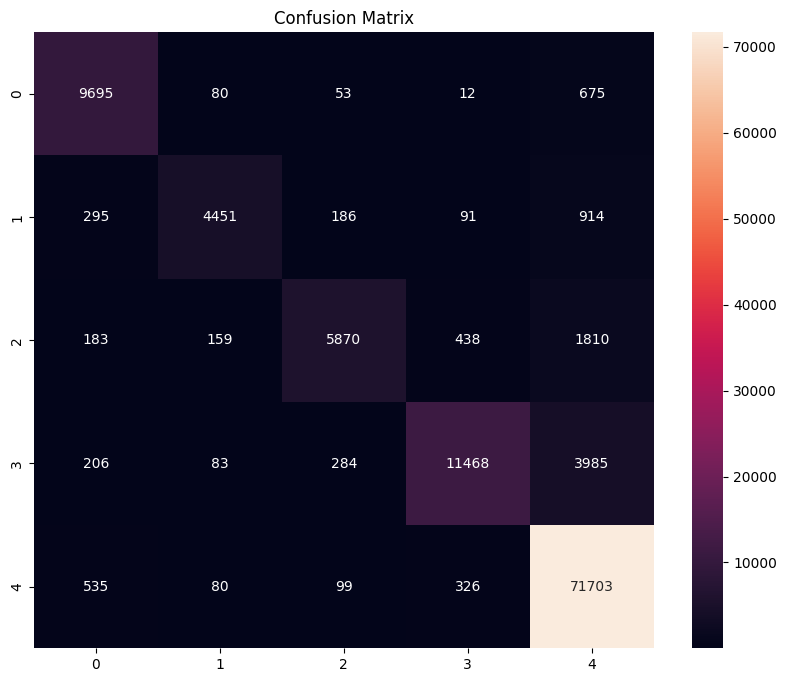

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test_combined)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

## Prediction

In [16]:
def make_prediction(model, tfidf_vectorizer, user_stats, text, user_id, timestamp):
    """
    Make prediction for a single review

    Parameters:
    -----------
    model: trained ensemble model
    tfidf_vectorizer: fitted TF-IDF vectorizer
    user_stats: DataFrame containing user statistics
    text: str, review text
    user_id: str, user identifier
    timestamp: datetime, time of review

    Returns:
    --------
    predicted_score: int, predicted rating (1-5)
    """
    try:
        text_features = tfidf_vectorizer.transform([text])

        timestamp = pd.to_datetime(timestamp)
        temporal_features = pd.DataFrame({
            'hour': [timestamp.hour],
            'day_of_week': [timestamp.dayofweek],
            'month': [timestamp.month],
            'is_weekend': [1 if timestamp.dayofweek in [5,6] else 0]
        })

        user_features = user_stats[user_stats['UserId'] == user_id]
        if user_features.empty:
            # If user not found, use default values
            user_features = np.array([
                [0,  # user_avg_score
                0,   # user_std_score
                1,   # user_review_count
                0   # user_avg_helpfulness
                ]
            ])
        else:
            user_features = user_features.drop('UserId', axis=1).values


        combined_features = np.hstack([
            text_features.toarray(),
            user_features,
            temporal_features
        ])

        predicted_score = model.predict(combined_features)[0]

        return int(predicted_score)

    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        return None


In [31]:
from datetime import datetime

sample_review = {
    'text': "This product is amazing! Really satisfied with the quality.",
    'user_id': "t-yh764f	",
    'timestamp': datetime.now()
}

predicted_rating = make_prediction(
    model=model,
    tfidf_vectorizer=tfidf,
    user_stats=df_user_features,
    text=sample_review['text'],
    user_id=sample_review['user_id'],
    timestamp=sample_review['timestamp']
)

print(f"Predicted Rating: {predicted_rating}")

Predicted Rating: 5
